# Omnigenity Optimization

This tutorial demonstrates how to optimize for omnigenity in DESC. It will go through an example using omnigenity with poloidally closed contours of magnetic field strength (OP), but the method is capable of optimizing for any general omnigenous magnetic fields as explained in [Dudt et al. (2024)](https://doi.org/10.1017/S0022377824000151).

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [2]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from desc.backend import jnp
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.magnetic_fields import OmnigenousField
from desc.objectives import (
    AspectRatio,
    CurrentDensity,
    FixCurrent,
    FixOmniBmax,
    FixOmniMap,
    FixPressure,
    FixPsi,
    GenericObjective,
    LinearObjectiveFromUser,
    ObjectiveFunction,
    Omnigenity,
)
from desc.optimize import Optimizer
from desc.plotting import plot_boozer_surface, plot_boundaries

plt.rcParams["font.size"] = 14

As an initial guess for the optimization, we will start with a boundary shape generated by an analytic model for (very approximate) quasi-poloidal symmetry (QP). 
In this example, we will seek a vacuum magnetic field with two field periods ($N_{FP}=2$), an aspect ratio of $R_0/a\leq10$, and a mirror ratio on axis of $\Delta=0.2$. 

In [5]:
surf = FourierRZToroidalSurface.from_qp_model(
    major_radius=1,
    aspect_ratio=10,
    elongation=3,
    mirror_ratio=0.2,
    torsion=0.1,
    NFP=2,
    sym=True,
)
# this value of Psi gives an average |B| on axis of about 1 T
# the Equilibrium class defaults to vacuum pressure and current profiles
eq = Equilibrium(Psi=3e-2, M=4, N=4, surface=surf)

Now that the equilibrium is initialized, we need to solve the fixed-boundary vacuum equilibrium: 

In [6]:
eq, _ = eq.solve(objective="force", verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.55 sec
Timer: Objective build = 2.17 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.04 sec
Timer: LinearConstraintProjection build = 8.26 sec
Number of parameters: 120
Number of objectives: 850
Timer: Initializing the optimization = 11.6 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial T

--------------------------------------------------------------------------
Let us make a copy of this initial equilibrium so that we can compare our final solution to it later and see how well the omnigenity optimization worked. 
By plotting the $|B|$ contours in Boozer coordinates, we can see that this equilibrium is already somewhat close to being omnigenous with poloidal contours, but far from perfect. 

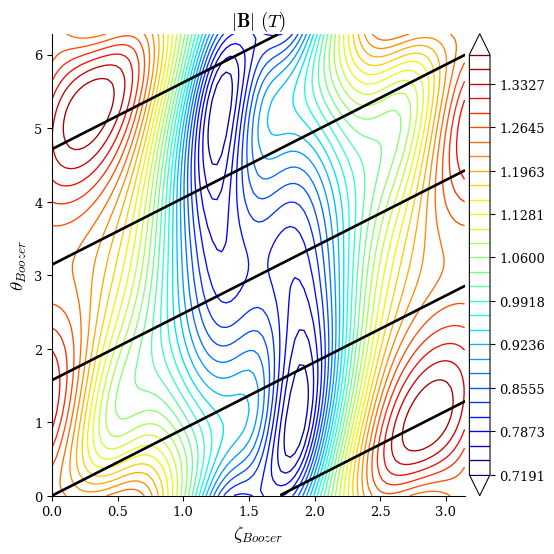

In [7]:
eq0 = eq.copy()
# defaults to the rho=1 surface
plot_boozer_surface(eq0, fieldlines=4);

In order to optimize the equilibrium for omnigenity, we need to create a target omnigenous magnetic field. 
The `OmnigenousField` class has two attributes that represent parameters in the omnigenous magnetic field model: 
- `B_lm` specifies the shape of the "magnetic well" on each flux surface. 
- `x_lmn` specifies how the well shape varies along different field lines. 

The helicity is given by the tuple of integers $(M, N)$, and is set to $(0, N_{FP})$ for omnigenity with poloidal contours in this example. 
The typical case for helical contours would be $(1, N_{FP})$, and for toroidal contours would be $(1, 0)$. 

We need to specify the resolution of the parameter space, given by the following integers: 
- `L_B` is the maximum power of $\rho$ used in the Chebyshev polynomial expansion for `B_lm`. 
- `M_B` is the number of spline knots used on each surface for `B_lm`. 
- `L_x` is the maximum power of $\rho$ used in the Chebyshev polynomial expansion for `x_lmn`. 
- `M_x` is the maximum mode number used in the cosine series expansion in $\eta$ for `x_lmn`. 
- `N_x` is the maximum mode number used in the Fourier series expansion in $\alpha$ for `x_lmn`. Quasi-symmetry corresponds to `N_x=0`. 

We provide initial values for the well shape parameters `B_lm` so that we can set the mirror ratio. 
The total number of parameters is `B_lm.size = M_B * (L_B + 1)`. 
In this example, the well shape on each surface is represented by three spline knots, and there is $\mathcal{O}(\rho)$ variation across the flux surfaces. 
Here we set only the constant terms of the Chebyshev polynomials such that the initial target field has the same magnetic well from $B_{\mathrm{min}}=0.8\mathrm{~T}$ to $B_{\mathrm{max}}=1.2\mathrm{~T}$ on each surface (corresponding to a mirror ratio of $\Delta=0.2$). 

The `x_lmn` parameters are left to their default values of 0, which corresponds to a quasi-poloidally symmetric (QP) initial target field. 
These parameters will not be fixed during the optimization, so the final result will not be constrained to QP symmetry. 


In [8]:
field = OmnigenousField(
    L_B=1,  # radial resolution of B_lm parameters
    M_B=3,  # number of spline knots on each flux surface
    L_x=1,  # radial resolution of x_lmn parameters
    M_x=1,  # eta resolution of x_lmn parameters
    N_x=1,  # alpha resolution of x_lmn parameters
    NFP=eq.NFP,  # number of field periods; should always be equal to Equilibrium.NFP
    helicity=(0, eq.NFP),  # helicity for poloidally closed |B| contours
    B_lm=np.array(  # magnetic well shape parameters
        [
            [0.8, 1.0, 1.2],  # the first M_well coefficients are the L_B=0 spline knots
            [0, 0, 0],
        ]  # the next M_well coefficients are the L_B=1 spline knots, etc.
    ).flatten(),
)

We can use the `field.compute` function to visualize what the current target well shape for this field is, with the minimum and maximum as we have prescribed. 
This magnetic well will be allowed to change during the optimization process according to how the `B_lm` coefficients change. 

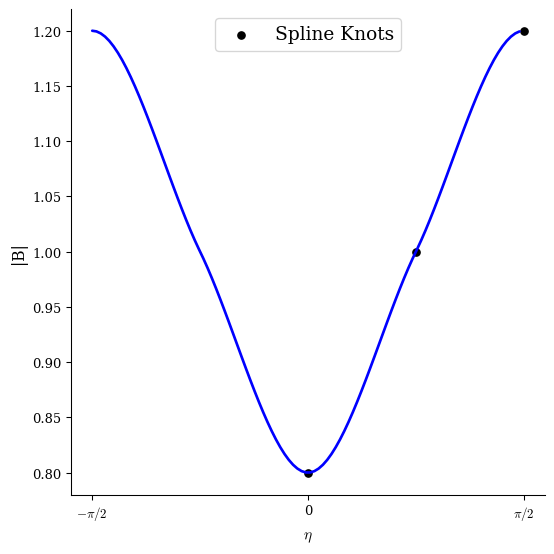

In [9]:
# plot initial target well |B|
grid_well = LinearGrid(rho=[0.0], M=50)
data_initial = field.compute("|B|", grid=grid_well)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(data_initial["eta"], data_initial["|B|"], c="b", lw=2)
ax.scatter(
    [0, np.pi / 4, np.pi / 2],
    field.B_lm[0 : field.M_B] - field.B_lm[field.M_B :],
    c="k",
    marker=".",
    label="Spline Knots",
    s=120,
)
ax.set_xticks([-np.pi / 2, 0, np.pi / 2])
ax.set_xticklabels(["$-\\pi/2$", "0", "$\\pi/2$"])
ax.set_xlabel("$\\eta$")
ax.set_ylabel("|B|")
ax.legend(loc="upper center");

Next we create the objective function for the optimization. 
We include one objective to keep the major radius at $R_0=1~m$, and another to keep the aspect ratio at $R_0/a\leq10$. 
The elongation will be unconstrained, but that is another common objective we could choose to include. 

We will also target omnigenity on two flux surfaces: $\rho=0.5$ and $\rho=1$. 
The `Omnigenity` objective class requires two different computational grids: 
- `eq_grid` is the grid used to compute the Boozer transform. 
- `field_grid` is the grid corresponding to $(\rho,\eta,\alpha)$ coordinates where the omnigenity residuals are minimized. 

A separate `Omnigenity` objective is required for each flux surface, but they all reference the same `Equilibrium` and `OmnigenousField`. Make sure both grids for each objective are at the desired surface and have `sym=False`! 

In [10]:
eq_half_grid = LinearGrid(rho=0.5, M=4 * eq.M, N=4 * eq.N, NFP=eq.NFP, sym=False)
eq_lcfs_grid = LinearGrid(rho=1.0, M=4 * eq.M, N=4 * eq.N, NFP=eq.NFP, sym=False)

field_half_grid = LinearGrid(rho=0.5, theta=16, zeta=8, NFP=field.NFP, sym=False)
field_lcfs_grid = LinearGrid(rho=1.0, theta=16, zeta=8, NFP=field.NFP, sym=False)

objective = ObjectiveFunction(
    (
        # target major radius of R0=1 m
        GenericObjective("R0", thing=eq, target=1.0, name="major radius"),
        # target aspect ratio R0/a<=10
        AspectRatio(eq=eq, bounds=(0, 10)),
        # omnigenity on the rho=0.5 surface
        Omnigenity(
            eq=eq,
            field=field,
            eq_grid=eq_half_grid,
            field_grid=field_half_grid,
            eta_weight=1,
        ),
        # omnigenity on the rho=1.0 surface
        Omnigenity(
            eq=eq,
            field=field,
            eq_grid=eq_lcfs_grid,
            field_grid=field_lcfs_grid,
            eta_weight=2,
        ),
    )
)

Next we set the optimization constraints. 
The `CurrentDensity`, `FixPressure`, `FixCurrent`, and `FixPsi` objectives ensure that we maintain a good vacuum equilibrium during the optimization. 

We also include three additional constraints that are unique to the omnigenity optimization: 
- A perfect omnigenous magnetic field must have a straight $B_{\mathrm{max}}$ contour in Boozer coordinates, and this is accomplished with the `FixOmniBmax` objective. 
- The `FixOmniMap` objective is used to fix values of the `field.x_lmn` parameters. 
In this OP example our $B_{\mathrm{max}}$ contour is located at $\zeta_B=0$, and this constraint is used to ensure that the $B_{\mathrm{min}}$ contour is located at $\zeta_B=\pi/N_{FP}$ on average. 
This constraint should always be true for stellarator symmetry. 
- The `LinearObjectiveFromUser` objective is used to fix the sum of values of the `field.B_lm` parameters. 
Here we use it to fix the values of $B_{\mathrm{min}}$ and $B_{\mathrm{max}}$ on axis to contrain the mirror ratio. 
The shape of the magnetic well will still have one degree of freedom on the magnetic axis, and the mirror ratio is unconstrained on other flux surfaces. 

In [11]:
def mirrorRatio(params):
    """Custom linear function to constrain the mirror ratio on axis."""
    B_lm = params["B_lm"]
    f = jnp.array(
        [
            B_lm[0] - B_lm[field.M_B],  # B_min on axis
            B_lm[field.M_B - 1] - B_lm[-1],  # B_max on axis
        ]
    )
    return f


constraints = (
    CurrentDensity(eq=eq),  # vacuum equilibrium force balance
    FixPressure(eq=eq),  # fix vacuum pressure profile
    FixCurrent(eq=eq),  # fix vacuum current profile
    FixPsi(eq=eq),  # fix total toroidal magnetic flux
    # ensure the B_max contour is straight in Boozer coordinates
    FixOmniBmax(field=field),
    # ensure the average B_min contour is at zeta_B=pi/NFP
    FixOmniMap(field=field, indices=np.where(field.x_basis.modes[:, 1] == 0)[0]),
    # fix the mirror ratio on the magnetic axis
    LinearObjectiveFromUser(mirrorRatio, field, target=[0.8, 1.2]),
)

Finally we are ready to run the optimization! 
We use a least-squares augmented Lagrangian optimizer, but the "proximal" least-squares optimizer would also work. 
Note that because we are optimizing multiple "things" (the equilibrium `eq` and the omnigenous field `field`) we must use `optimizer.optimize()` instead of `Equilibrium.optimize()`. 

In [12]:
optimizer = Optimizer("lsq-auglag")
(eq, field), _ = optimizer.optimize(
    (eq, field), objective, constraints, x_scale="ess", maxiter=100, verbose=3
)

Building objective: major radius
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 44.3 ms
Building objective: omnigenity
Precomputing transforms
Timer: Precomputing transforms = 1.29 sec
Building objective: omnigenity
Precomputing transforms
Timer: Precomputing transforms = 79.3 ms
Timer: Objective build = 1.58 sec
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: fixed omnigenity B_max
Building objective: fixed omnigenity map
Building objective: custom linear
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.20 sec
Building objective: current density
Precomputing transforms
Timer: Precomputing transforms = 107 ms
Timer: Objective build = 178 ms
Timer: LinearConstraintProjection build = 4.19 sec
Timer: Li

Since we used an augmented Lagrangian optimizer, the nonlinear equilibrium constraint is not guaranteed to be satisfied. 
It is typically smart to re-solve the fixed-boundary equilibrium after optimization to ensure we have low force balance residuals. 

In [13]:
eq, _ = eq.solve(objective="force", verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 142 ms
Timer: Objective build = 163 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 161 ms
Timer: LinearConstraintProjection build = 1.34 sec
Number of parameters: 120
Number of objectives: 850
Timer: Initializing the optimization = 1.67 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust R

Let us again plot the $|B|$ contours in Boozer coordinates to get a qualitative picture of the solution. 
Although still not perfect, the optimized equilibrium is clearly more omnigenous compared to the initial one we plotted above. 
Now almost all of the contours are closed poloidally, except for a few "puddles" near the minimum of the field strength. 
The omnigenity could probably be further improved by using higher resolutions and running for more iterations. 

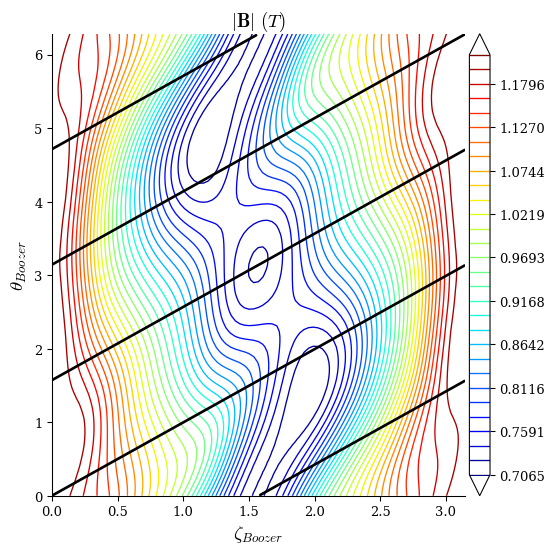

In [14]:
# defaults to the rho=1 surface
plot_boozer_surface(eq, fieldlines=4);

We can also plot the omnigenous field that was used as a target during the optimization, as shown below. 
This is a perfectly omnigenous magnetic field and is physically unrealistic to achieve by an equilibrium, but it represents the "closest" omnigenous field to the optimized solution. 
In the limit of lower omnigenity errors, this plot and the one from the equilibrium plotted above should approach becoming identical. 

Plotting the omnigenous field in Boozer coordinates requires a value for the rotational transform, so we use $\iota$ from the optimized equilibrium. 

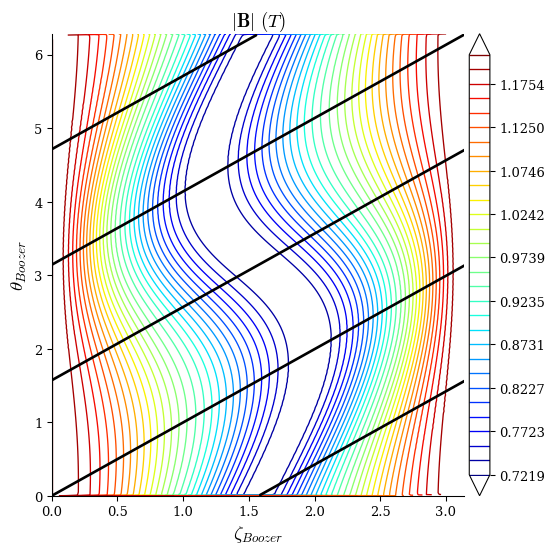

In [15]:
# compute the rotational transform at rho=1
grid = LinearGrid(M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
iota = eq.compute("iota", grid=grid)["iota"][0]

plot_boozer_surface(field, iota=iota, fieldlines=4);

It is also useful to compare the boundaries of the initial and optimized equilibria, as shown in this plot. 
This reveals that the optimization improved the omnigenity by adding some torsion and elongation. 

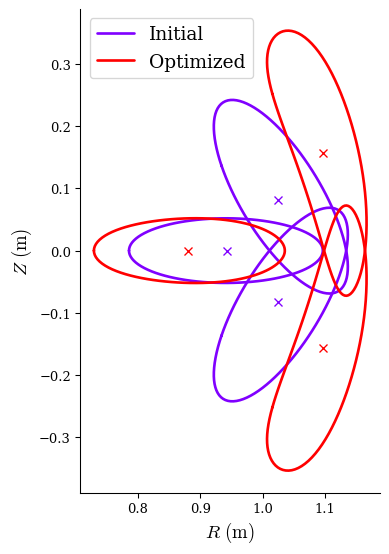

In [16]:
plot_boundaries((eq0, eq), labels=["Initial", "Optimized"], phi=3, lw=2);

We can plot the magnetic well again to see how its shape changed during the optimization. 

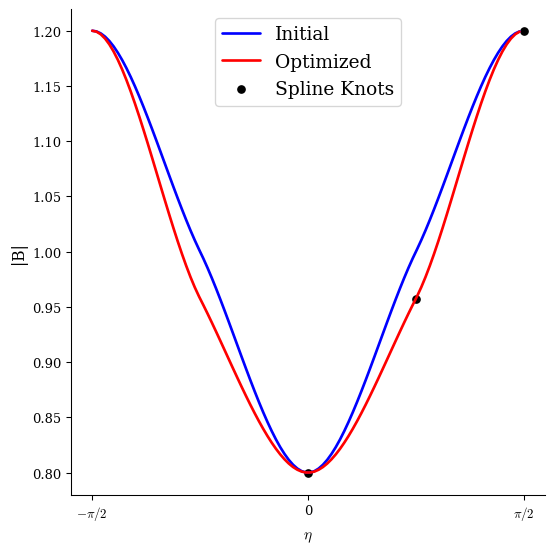

In [17]:
# plot final target well |B|
data_optimal = field.compute("|B|", grid=grid_well)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(data_initial["eta"], data_initial["|B|"], c="b", lw=2, label="Initial")
ax.plot(data_optimal["eta"], data_optimal["|B|"], c="r", lw=2, label="Optimized")
ax.scatter(
    [0, np.pi / 4, np.pi / 2],
    field.B_lm[0 : field.M_B] - field.B_lm[field.M_B :],
    c="k",
    marker=".",
    label="Spline Knots",
    s=120,
)
ax.set_xticks([-np.pi / 2, 0, np.pi / 2])
ax.set_xticklabels(["$-\\pi/2$", "0", "$\\pi/2$"])
ax.set_xlabel("$\\eta$")
ax.set_ylabel("|B|")
ax.legend(loc="upper center");